# **Tensorflow-Keras and Scikit-Learn With MLRun**

_______________________________________________________________________________

MLRun is an open-source Python package that provides a framework for running machine learning tasks transparently in multiple, scalable, runtime environments.  MLRun provides tracking of code, metadata, inputs, outputs and the results of machine learning pipelines. 

In this notebook we"ll compose a pipeline that deploys a classifier model, and uses it as the input in a training and validation step. We'll be working with a synthetic features matrix of dimension 10 million rows by 20 features and a binary label.  The model will be a 2-layer neural net classifier using **[tensorflow-keras](https://www.tensorflow.org/)** (v2.0.0b1), without gpu support.

The dataset we create is balanced, however there is a `weight` parameter in the data generator function specifying the fraction of observations that are labeled 0/False. The number of samples and features are also parameters.  The demonstration could be modified easily to allow for a more fine-grained control over the simulated dataset either by adding more parameters or replacing the underlying function altogether.

The training and validation step employs a scikit learn `Pipeline` to perform feature engineering. Some of the feature engineering needs to be done _**after**_ the train-valid-test set split. In some preprocessing scenarios we might estimate a data transformation on the training set before model training, and then apply the estimate to the validation and test sets before prediction. Since we need to perform the same transformation pre-inference, all pipeline model steps are stored.

Serializing models can be challenging for number of reasons:  a pipeline with multiple steps may require just as many encoding and decoding routines--applying Python's `pickle` to a Keras model that has been wrapped in a scikit-learn api fails.  Since we have the model architecture in a class definition, all we need to do is save the weights.  Some steps in a pipeline may have no internal state to store, while others can be stored and loaded using `pickle`.  Most of it all boils down to storing dicts/json with numpy objects.

One of the upsides of the present architecture is that we can mix many simulations of data with a given model estimator, or many models with a given data sample and track everything in **MLRun**.  Research, development, and deployment, all on one page, running under multiple configurations, limited only by the compute resources at our disposal.


#### **notebook take-aways**
* write and test reusable and replaceable **[MLRun](https://github.com/mlrun)** components in a notebook, file or github repository
* store and load models
* run the components as a **[KubeFlow](https://www.kubeflow.org/)** pipeline

<a id='top'></a>
#### **steps**
**[nuclio code section](#nuclio-code-section)**<br>
    - [nuclio's ignore](#ignore)<br>
    - [function dependencies](#function-dependencies)<br>

**[components](#components)**<br>
    - [supporting functions](#imports)<br>
    - [data simulation](#data_generator)<br>
    - [feature engineering](#feateng)<br>
    - [a classifier](#classifier)<br>
    - [save and load pipeline model](#save-load)<br>
    - [training and validation](#train)<br>
**[local tests](#local-testing)**<br>
**[remote tests](#remote)**<br>
**[compose pipeline](#compose)**<br>
**[run](#run)**<br>


______________________________________________

<a id="nuclio-code-section"></a>
# **nuclio code section**

<a id='ignore'></a>
### _nuclio's **ignore** notation_

You'll write all the code that gets packaged for execution between the tags ```# nuclio: ignore```, meaning ignore all the code here and above, and ```# nuclio: end-code```, meaning ignore everything after this annotation.  The **[docs](https://github.com/nuclio/nuclio-jupyter#creating-and-debugging-functions-using-nuclio-magic)** also suggest another approach: we can use ```# nuclio: start``` at the first relevant code cell instead of marking all the cells above with ```# nuclio: ignore```.

See the **[nuclio-jupyter](https://github.com/nuclio/nuclio-jupyter)** repo for further information on these and many other **[nuclio magic commands](https://github.com/nuclio/nuclio-jupyter#creating-and-debugging-functions-using-nuclio-magic)** that make it easy to transform a Jupyter notebook environment into a platform for developing production-quality, machine learning systems.

The following two lines _**should be in the same cell**_ and mark the start of your mchine learning coding section:

In [1]:
# nuclio: ignore
import nuclio 

<a id="function-dependencies"></a>
### _function dependencies_

The installs made in the section **[Setup](#Setup)** covered the Jupyter environment within which this notebook runs.  However, we need to ensure that all the dependencies our nuclio function relies upon (such as ```matplotlib```, ```sklearn```, ```lightgbm```), will be available when that code is wrapped up into a nuclio function _**on some presently unknown runtime**_.   Within the nuclio code section we can ensure these dependencies get built into the function with the ```%nuclio cmd``` magic command.

In [2]:
%%nuclio cmd -c
rm /conda/lib/python3.6/site-packages/seaborn* -rf
pip install -U -q seaborn
pip install -U -q matplotlib
pip install -U -q tensorflow==2.0.0b1
pip install -U -q scikit-learn
pip install -U -q pyarrow
pip install -U -q pandas 
pip install -U -q numpy==1.17.4
pip install -U -q git+https://github.com/yjb-ds/functions-demo.git
    
pip uninstall -y mlrun
pip install -U -q git+https://github.com/mlrun/mlrun.git@development

We"ll use a standard base image here, however the build step can be shortened by preparing images with pre-installed packages.

In [3]:
%nuclio config spec.build.baseImage = "python:3.6-jessie"

%nuclio: setting spec.build.baseImage to 'python:3.6-jessie'


<a id="support"></a>
### _imports_


In [2]:
import os
import io
from pickle import dump, load
import json
import importlib
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import pyarrow as pa

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import Constant

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

In [8]:
from typing import Any, Union, Optional, List, Callable

In [9]:
from mlrun.artifacts import TableArtifact, PlotArtifact
from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem

In [10]:
from functions.models import KerasClassifier, FeaturesEngineer

<a id='paths'></a>
### _paths and parameters_

In [11]:
TARGET_PATH = '/User/mlrun/simdata'

# data simulation and ml training parameter
BATCH_SIZE = 1_024
LEARNING_RATE = 0.1
EPOCHS= 3
N_SAMPLES = 1_000_000
M_FEATURES = 20
CLASS_BALANCE = 0.5
DROPOUT = 0.5

<a id="components" ></a>
______________________________________________

# **components**

<a id='data_generator'></a>
## **data generator**

In this function we wrap a scikit-learn data generator and log the data and header as artifacts:

In [19]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable]

In [20]:
h = .02  

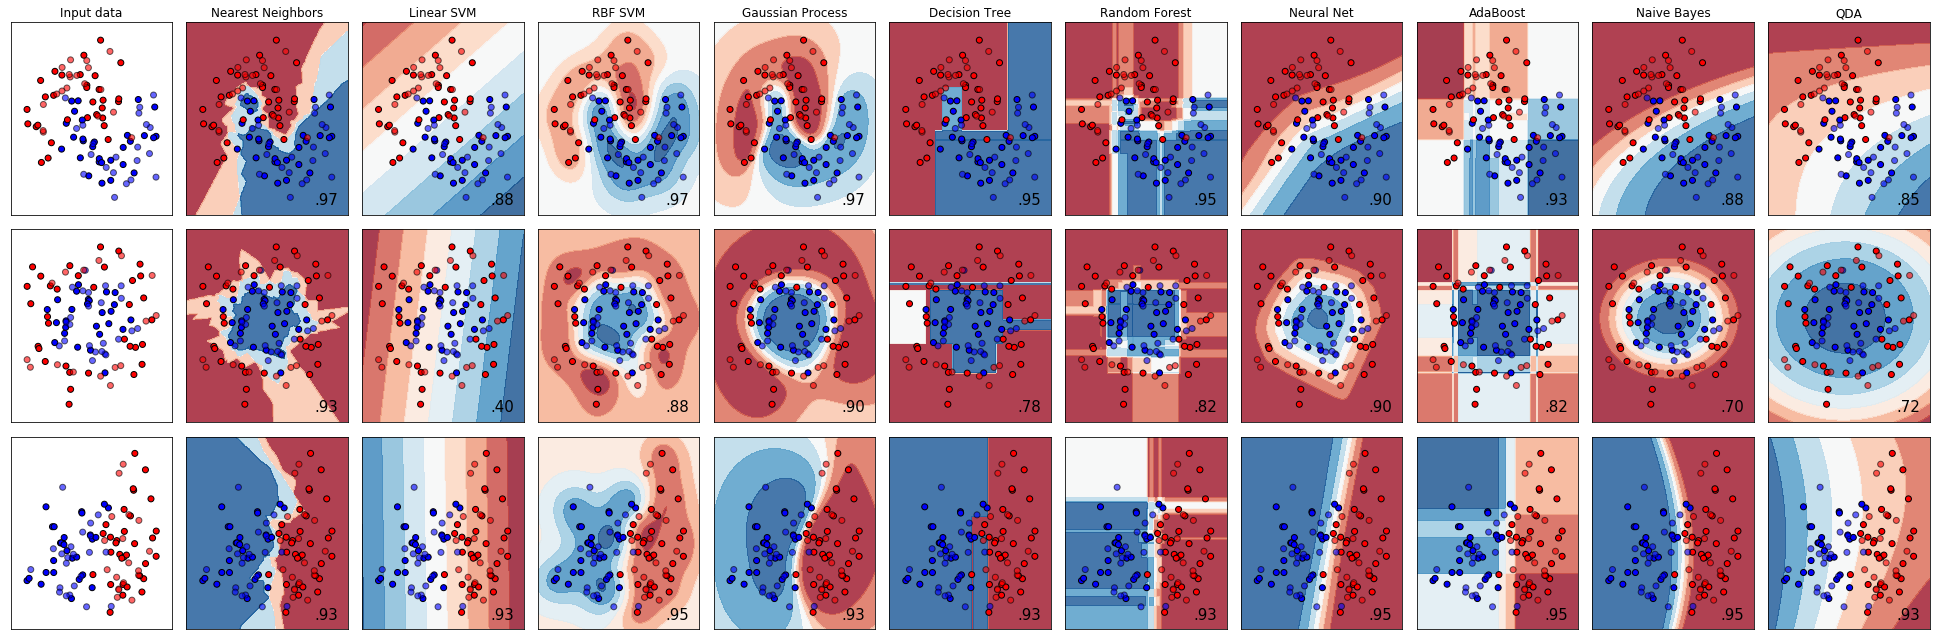

In [21]:
figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

<a id='feateng'></a>
## **feature engineering**

This class implements the scikit-learn transformer API, enabling it to fit into an sklearn `Pipeline` as a step.<br>

<a id="classifiers"></a>
## **classifiers**

The following is a list of classifiers we will run against the artificial dataset

In [18]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [16]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [14]:
def my_classifier_model_generator(
    metrics: list = [],
    input_size: int = 20,
    dropout: float = 0.5,
    output_bias: float = None,
    learning_rate: float = 1e-3
):
    """Generate a super simple classifier

    :param metrics:      select metrics to be evaluated
    :param output_bias:  layer initializer
    :param input_size:   number of features, size of input
    :param dropout:      dropout frequency
    :param learning_rate:

    returns a compiled keras model used as input to the KerasClassifer wrapper
    """
    if output_bias is not None:
        output_bias = Constant(output_bias)

    model = Sequential(
        [
            Dense(16, activation="relu", input_shape=(input_size,)),
            Dropout(dropout),
            Dense(1, activation="sigmoid", bias_initializer=output_bias),
        ]
    )

    model.compile(
        optimizer=Adam(lr=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=metrics
    )

    return model

In [15]:
METRICS = [keras.metrics.BinaryAccuracy(name="accuracy")]

<a id='train'></a>
## **training and validation**

In this notebook demonstration we follow standard practice by wrapping the training/validation and test steps into the same method.

In [16]:
def _plot_validation(
    context: MLClientCtx, 
    train_metric,
    valid_metric,
    title: str = "training validation results",
    xlabel: str = "epoch",
    ylabel: str = "",
    target_path: str = "",
    key: str = "",
) -> None:
    """Plot train and validation loss curves from a metrics table in an
    artifact store.
    
    These curves represent the training round losses from the training
    and validation sets.
    :param train_metric:    train metric
    :param valid_metric:    validation metric
    :param title:           plot title
    :param xlabel:          X-axis label
    :param ylabel:          Y-axis label
    :param target_path:     save plot in this folder
    :param key:             plot's key in the artifact store
    """
    plt.plot(train_metric)
    plt.plot(valid_metric)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(["train", "valid"])
    fig = plt.gcf()

    plotpath = os.path.join(target_path, "history.png")
    plt.savefig(plotpath)
    context.log_artifact(PlotArtifact('training-validation-plot',
                                      body=fig,
                                      target_path=plotpath))

    # to ensure we don't overwrite this figure when creating the next:
    plt.cla()
    plt.clf()
    plt.close()

In [17]:
def _plot_roc(
    context: MLClientCtx, 
    y_labels,
    y_probs,
    title: str = "roc curve",
    xlabel: str = "false positive rate",
    ylabel: str = "true positive rate",
    fmt: str = "png",
    target_path: str = "",
    key: str = "",
) -> None:
    """Plot an ROC curve from test data saved in an artifact store.
    :param y_labels:        test data labels
    :param y_probs:         test data 
    :param title:           plot title
    :param xlabel:          X-axis label (not tick labels)
    :param ylabel:          Y-axis label (not tick labels)
    :param fmt:             plot file image format (png, jpg, ...)
    :param target_path:     save plot in this folder
    :param key:             plot's key in the artifact store                
    """
    fpr_xg, tpr_xg, _ = roc_curve(y_labels, y_probs)
    plt.plot([0, 1], [0, 1], "k--")
    plt.plot(fpr_xg, tpr_xg, label="roc")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc="best")
    fig = plt.gcf()

    plotpath = os.path.join(target_path, "roc.png")
    fig.savefig(plotpath, format=fmt)
    context.log_artifact(PlotArtifact('roc', body=fig))
    
    # to ensure we don't overwrite this figure when creating the next:
    plt.cla()
    plt.clf()
    plt.close()

In [18]:
def _plot_confusion_matrix(
    context: MLClientCtx, 
    labels,
    predictions,
    title: str = "confusion matrix",
    axislabels: List = None,
    target_path: str = "",
    key: str = "",
) -> None:
    """Create a confusion matrix.
    Plot and save a confusion matrix using test_data from a
    pipeline step.  The plot is generated usung default arguments.
    The present example could be extended by including a parameters `dict`
    that is passed through to sklearn's `confusion_matrix`,
    `ConfusionMatrixDisplay`, and matplotlib `plot`.
    :param labels:          test data labels
    :param predictions:     test data predictions
    :param title:           plot title
    :param axislabels:      list of classes, for labeling axes
    :param target_path:     save plot in this folder
    :param key:             plot's key in the artifact store
    """
    cm = confusion_matrix(labels,
                          predictions,
                          sample_weight=None,
                          labels=axislabels,
                          normalize='all')
    sns.heatmap(cm, annot=True, cmap="Blues")
    plotpath = os.path.join(target_path, "confusion.png")
    fig = plt.gcf()
    fig.savefig(plotpath)
    context.log_artifact(PlotArtifact('confusion_matrix', body=fig))

    # to ensure we don't overwrite this figure when creating the next:
    plt.cla()
    plt.clf()
    plt.close()

In [19]:
def _plot_importance(
    context: MLClientCtx, 
    model,
    header: List = [],
    title: str = 'LightGBM Features',
    fmt: str = "png",
    target_path: str = '',
    key: str = ''
)-> None:
    """Display estimated feature importances.
    
    :param model:       fitted lightgbm model
    :param header:      list of feature names
    :param title:       ('LightGBM Features') plot title
    :param fmt:         plot file image format (png, jpg, ...)
    :param target_path: destination folder for files
    :param key:         key of artifact in artifact store
    
    """
    # create a feature importance table with desired labels
    zipped = zip(model.feature_importances_, header)
    
    feature_imp = pd.DataFrame(sorted(zipped), columns=['freq','feature']
                              ).sort_values(by="freq", ascending=False)
    
    plt.figure(figsize=(20, 10))
    sns.barplot(x="freq", y="feature", data=feature_imp)
    plt.title(title)
    plt.tight_layout()
    fig = plt.gcf()
    plotpath = os.path.join(target_path, "feature-importances.png")
    fig.savefig(plotpath)
    context.log_artifact(PlotArtifact('feature-importances-plot', body=fig))

    # feature importances are also saved as a table:
    tablepath = os.path.join(target_path, "feature-importances-table.csv")
    feature_imp.to_csv(tablepath)
    context.log_artifact(TableArtifact('feature-importances-table',
                                       target_path=tablepath))
    
    # to ensure we don't overwrite this figure when creating the next:
    plt.cla()
    plt.clf()
    plt.close()

In [20]:
def class_instance(module_class: str, target_path: Optional[str] = None):
    """Instantiate a class from strings
    
    :param module_class:   full package and module string
    :param target_path:    (Optional) destination folder for the serialized
                           class
    
    For example, to instantiate a sklearn StandardScaler,
    use:
    >>> ss = class_instance('sklearn.preprocessing.data.StandardScaler')
     
    :param module_class:   module and class name
    
    """
    splits = module_class.split(".")
    module = ".".join(splits[:-1])
    aclass = splits[-1]

    module = importlib.import_module(module)
    class_ = getattr(module, aclass)
    if target_path:
        setattr(class_, 'target_path', target_path)
    
    return class_

In [21]:
def log_model(
    context: MLClientCtx,
    model,
    history,
    test_data: pd.DataFrame, 
    header: List = [],
    target_path: str = '',
    name: str = 'model.pkl',  # with file extension
    key: str = 'model',
    labels: dict = {}
):
    """log a classifier model to the artifact store
    
    :param context:       function context
    :param model:         estimated model
    :param history:       training-validation metrics
    :param test_data:     test labels and test predictions
    :param header:        features labels
    :param target_path:   destintion folder for file artifacts
    :param name:          name of model file (or, prefix to model files)
    :param key:           key of model in artifact store
    :param labels:        model artifact labels
    
    Save an estimated model along with metadata, it's training-validation metrics 
    history and plots, roc curve, confusion matrix and feature importances.  
    """
    loss = np.asarray(history['train']['binary_logloss'], dtype=np.float)
    val_loss = np.asarray(history['valid']['binary_logloss'], dtype=np.float)
    
    _plot_validation(context, loss, val_loss, target_path=target_path, key='training-validation-metrics')
    _plot_roc(context, test_data.y_test, test_data.y_probs, target_path=target_path, key='roc-curve')
    _plot_confusion_matrix(context, test_data.y_test, test_data.y_pred, target_path=target_path, key='confusion-matrix')
    
    if hasattr(model, 'feature_importances_'):
        _plot_importance(context, model, header, target_path=target_path, key='feature-importances')
    else:
        # do something else here to calculate importances (use a generic package like SHAPELY)
        pass
   
    # save the model and log  as an artifact
    filepath = os.path.join(target_path, name)
    dump(model, open(filepath, 'wb'))
    context.log_artifact(key,
                         target_path=filepath)
                         #,
                         #labels=labels)    

In [32]:
def train(
    context: MLClientCtx,
    data_src_file: str,
    engineer_cls: str,
    scaler_cls: str,
    classifier_cls: str,
    #classifier_model: Optional[Callable] = None, 
    classifier_params: Optional[dict] = {}, 
    target_path: str = '',
    key: str = '',
    name: str = '',
    test_size: float = 0.1,
    valid_size: float = 0.3,
    batch_size: int = 1024,
    epochs: int = 5,
    verbose: bool = True,
    random_state: int = 1,
    ) -> None:
    """Train, validate, test and save a classifier model pipeline.
    
    Here we split the data, instantiate our pipeline and its models, and proceed
    to training and validation.
    
    The target_path defines the base folder where artifacts will be stored.  Since we
    intend to save both the model (and its components), the test set and 
    its predictions, and the history of metric estimates we provide three keys.
    
    :param context:             function context
    :param data_src_file:       location of cleaned input
    :param engineer_cls:        feature engineering class
    :param scaler_cls:          scaler class
    :param classifier_cls:      classifier class    
    :param classifier_model:    if the classifier has a model generator (Keras, Pytorch
                                using sklearn API)
    :param classifier_params:   parameters used in classifier model
    :param target_path:         destination (folder) for artifact files
    :param key:                 model key in the artifact store
    :param name:                name of model file
    :param test_size:           (0.1) test set size as fraction
    :param valid_size:          (0.3) validation set size as fraction
    :param batch_size:          (1024) network feed batch size
    :param epochs:              (5) training epochs
    :param verbose:             (default True) Show metrics for 
                                training/validation steps
        
    Also included for demonstration are a randomly selected sample
    of training parameters:
    :param learning_rate: Step size at each iteration, constant.
    """
    srcfilepath = os.path.join(target_path, data_src_file)
    raw = pd.read_parquet(srcfilepath, engine='pyarrow')
    
    train, test = train_test_split(raw, test_size=test_size)
    train, valid = train_test_split(train, test_size=valid_size)
    
    ytrain = train.pop('labels')
    yvalid = valid.pop('labels')
    ytest = test.pop('labels')

    # instantiate features engineer, scaler and classifier
    Engineer = class_instance(engineer_cls)
    Scaler = class_instance(scaler_cls)
    Classifier = class_instance(classifier_cls, target_path=target_path)
    
    if my_classifier_model_generator:
        pipe = Pipeline(
            steps=[('engineer', Engineer()),
                   ('scaler', Scaler()),
                   ('classifier', Classifier(my_classifier_model_generator, **classifier_params))]
                   #('classifier', Classifier(my_classifier_model_generator, input_size=20))]
        )
    else:
        pipe = Pipeline(
            steps=[('engineer', Engineer()),
                   ('scaler', Scaler()),
                   ('classifier', Classifier(**classifier_params))])
                   #('classifier', Classifier(input_size=20))])
        
    pipe.fit(train, ytrain,
             classifier__epochs=epochs, 
             classifier__batch_size=batch_size,
             classifier__validation_split=0.25) # fudge

    # check to see if 'predict_proba' exists for this extimator:
    if hasattr(pipe, 'predict_proba'):
        ypred_probs = pipe.predict_proba(test)[:, 1]
        ypred = np.where(ypred_probs >= 0.5, 1, 0)
    else:
        ypred = pipe.predict(test)
        ypred_probs = []

        # we can eliminate one of y_pred or y_probs
    test_data = dict({
        'y_test': ytest.values,
        'y_pred': ypred, 
        'y_probs': ypred_probs
    })
        
    acc = accuracy_score(ytest, ypred)
    context.log_result("accuracy", float(acc))

    # keras metrics history
    history = dict({
        'train': {'binary_logloss' : pipe.named_steps.classifier.model.history.history['loss']},
        'valid': {'binary_logloss' : pipe.named_steps.classifier.model.history.history['val_loss']},
    })
    
    log_model(context, 
          pipe, 
          history, 
          pd.DataFrame({'y_test': ytest.values, 
                        'y_pred': ypred, 
                        'y_probs': ypred_probs}),
          target_path=target_path,
          header=list(raw),
          name=name, 
          key=key)
          #, 
          #labels=labels)

#### _end of nuclio function definition_

In [23]:
# nuclio: end-code

<a id="local-testing" ></a>
______________________________________________

# **testing your code locally**

The function can be run locally and debugged/tested before deployment:

In [24]:
from mlrun import (mlconf,
                   code_to_function,
                   new_function,
                   NewTask,
                   new_model_server,
                   mount_v3io)  

Set MLRun's DB path.  MLRun wil generate and store all of its tracking and metadata to the `MLRUN_DBATH` environment variable.  We have set a `TARGET_PATH` earlier in this notebook in the above section **[paths and parameters](#paths)**.

In [25]:
mlconf.dbpath = 'http://mlrun-api:8080'

In [30]:
workflow = new_function()

In [31]:
datagen_run = workflow.run(
    name='data generator',
    handler=create_binary_classification,
    params={
        'n_samples':      N_SAMPLES,
        'm_features':     M_FEATURES,
        'weight':         CLASS_BALANCE,
        'target_path':    TARGET_PATH,
        'key':          'simdata'})

[mlrun] 2020-01-16 13:04:13,499 log artifact header at /User/mlrun/simdata/header.json, size: None, db: Y



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...062ee0,0,Jan 16 13:04:11,completed,data generator,host=jupyter-1-6c8766ddb7-rp87j,,n_samples=1000000m_features=20weight=0.5target_path=/User/mlrun/simdatakey=simdata,,header


to track results use .show() or .logs() or in CLI: 
!mlrun get run afe532ee873b437fb438486b8c062ee0  , !mlrun logs afe532ee873b437fb438486b8c062ee0 
[mlrun] 2020-01-16 13:04:15,451 run executed, status=completed


In [33]:
train_run = workflow.run(
    name='train, validate and store model',
    handler=train,
    params={
        'data_src_file':    'simdata-1e06X20.parquet',
        'scaler_cls':       'sklearn.preprocessing.data.StandardScaler',
        'engineer_cls':     'functions.models.FeaturesEngineer',
        'classifier_cls':   'functions.models.KerasClassifier',
        #'classifier_model':  my_classifier_model_generator,
        'classifier_params': {'input_size':20},
        'target_path':     TARGET_PATH,
        'name':            'model.pkl',
        'key':             'model',
        'batch_size':      BATCH_SIZE,
        'epochs':          3})

Train on 472500 samples, validate on 157500 samples
Epoch 1/3
472500/472500 [==============================] - 1s 3us/sample - loss: 0.4235 - val_loss: 0.2363
Epoch 2/3
472500/472500 [==============================] - 1s 2us/sample - loss: 0.2481 - val_loss: 0.1634
Epoch 3/3
472500/472500 [==============================] - 1s 2us/sample - loss: 0.1953 - val_loss: 0.1322
[mlrun] 2020-01-16 13:08:02,796 log artifact training-validation-plot.html at /User/mlrun/simdata/history.png, size: 18696, db: Y
[mlrun] 2020-01-16 13:08:02,979 log artifact roc.html at roc.html, size: 19159, db: Y
[mlrun] 2020-01-16 13:08:03,243 log artifact confusion_matrix.html at confusion_matrix.html, size: 9440, db: Y
GETSTATE
[mlrun] 2020-01-16 13:08:03,336 log artifact model at /User/mlrun/simdata/model.pkl, size: None, db: Y



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...aa2129,0,Jan 16 13:07:55,completed,"train, validate and store model",host=jupyter-1-6c8766ddb7-rp87j,,data_src_file=simdata-1e06X20.parquetscaler_cls=sklearn.preprocessing.data.StandardScalerengineer_cls=functions.models.FeaturesEngineerclassifier_cls=functions.models.KerasClassifierclassifier_params={'input_size': 20}target_path=/User/mlrun/simdataname=model.pklkey=modelbatch_size=1024epochs=3,accuracy=0.95738,training-validation-plot.htmlroc.htmlconfusion_matrix.htmlmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 1735652826bb49aaaeede8226aaa2129  , !mlrun logs 1735652826bb49aaaeede8226aaa2129 
[mlrun] 2020-01-16 13:08:03,393 run executed, status=completed


<a id="image"></a>
#### _Create a deployment image_

Once debugged you can create a reusable image, and then deploy it for testing. In the following line we are converting the code block between the ```#nuclio: ignore``` and ```#nuclio: end-code``` to be run as a KubeJob. _**It is important to ensure that this function has been `deploy`ed at least once, and that you have access to it.**_

In [34]:
tfkeras_job = code_to_function(name='tfkeras_job',
                               runtime="job").apply(mount_v3io())

# set this to True so that updates to our git package are reflected in the built image,
# but please note however that this may lengthen image build times:

In [35]:
# tfkeras_job.spec.no_cache = True

In [39]:
# tfkeras_job.deploy()
# other options:
# ignore if exists
# save and/or export

In [ ]:
#tfkeras_job.with_code()

<a id="remote"></a>
# **test your code remotely**

In [38]:
task = NewTask()

task.with_params(
    n_samples=N_SAMPLES,
    m_features=M_FEATURES,
    weight=CLASS_BALANCE,
    target_path=TARGET_PATH,
    key='simdata')

nrun = tfkeras_job.run(task, handler='create_binary_classification', out_path=TARGET_PATH)

[mlrun] 2020-01-16 13:17:58,793 starting run create_binary_classification uid=4f3194306e7c440f9108390d6e0c81d9  -> http://mlrun-api:8080
[mlrun] 2020-01-16 13:17:58,945 Job is running in the background, pod: create-binary-classification-z6rr5
2020-01-16 13:18:08.152271: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2020-01-16 13:18:08.157964: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2499995000 Hz
2020-01-16 13:18:08.158794: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5bf9fb0 executing computations on platform Host. Devices:
2020-01-16 13:18:08.158816: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
[mlrun] 2020-01-16 13:18:10,168 log artifact header at /User/mlrun/simdata/header.json, size: None, db: Y

[mlrun] 2020-01-16 13:18:11,933 run executed, status=completed
final st

uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...0c81d9,0,Jan 16 13:18:08,completed,tfkeras-job,host=create-binary-classification-z6rr5kind=jobowner=admin,,key=simdatam_features=20n_samples=1000000target_path=/User/mlrun/simdataweight=0.5,,header


to track results use .show() or .logs() or in CLI: 
!mlrun get run 4f3194306e7c440f9108390d6e0c81d9  , !mlrun logs 4f3194306e7c440f9108390d6e0c81d9 
[mlrun] 2020-01-16 13:18:18,124 run executed, status=completed


In [40]:
task.with_params(
    data_src_file='simdata-1e06X20.parquet',
    scaler_cls='sklearn.preprocessing.data.StandardScaler',
    engineer_cls='functions.models.FeaturesEngineer',
    classifier_cls='functions.models.KerasClassifier',
    #classifier_model=my_classifier_model_generator,
    classifier_params= {'input_size':20},
    target_path=TARGET_PATH,
    name='model.pkl',
    key='model',
    batch_size=BATCH_SIZE,
    epochs=3)

nrun2 = tfkeras_job.run(task, handler='train', out_path=TARGET_PATH)

[mlrun] 2020-01-16 13:18:23,837 starting run train uid=ca58459ea36345309cd03999101e3af5  -> http://mlrun-api:8080
[mlrun] 2020-01-16 13:18:23,990 Job is running in the background, pod: train-vjw84
2020-01-16 13:18:33.234972: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2020-01-16 13:18:33.240288: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2499995000 Hz
2020-01-16 13:18:33.241107: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x51c2240 executing computations on platform Host. Devices:
2020-01-16 13:18:33.241131: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2020-01-16 13:18:35.391089: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1483] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU

uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...1e3af5,0,Jan 16 13:18:33,": import of module 'main' failed"">error",tfkeras-job,host=train-vjw84kind=jobowner=admin,,batch_size=1024classifier_cls=functions.models.KerasClassifierclassifier_params={'input_size': 20}data_src_file=simdata-1e06X20.parquetengineer_cls=functions.models.FeaturesEngineerepochs=3key=modelname=model.pklscaler_cls=sklearn.preprocessing.data.StandardScalertarget_path=/User/mlrun/simdata,accuracy=0.96257,training-validation-plot.htmlroc.htmlconfusion_matrix.html


to track results use .show() or .logs() or in CLI: 
!mlrun get run ca58459ea36345309cd03999101e3af5  , !mlrun logs ca58459ea36345309cd03999101e3af5 
[mlrun] 2020-01-16 13:18:43,167 run executed, status=error
runtime error: Can't pickle <function my_classifier_model_generator at 0x7ff37f2b4378>: import of module 'main' failed


RunError: Can't pickle <function my_classifier_model_generator at 0x7ff37f2b4378>: import of module 'main' failed

<a id="compose"></a>
# **Create a KubeFlow Pipeline from our functions**

Our pipeline will consist of two steps, ```data_generator``` and ```train```.

For complete details on KubeFlow Pipelines please refer to the following docs:
1. **[KubeFlow pipelines](https://www.kubeflow.org/docs/pipelines/)**.
2. **[kfp.dsl Python package](https://kubeflow-pipelines.readthedocs.io/en/latest/source/kfp.dsl.html#module-kfp.dsl)**.

Please note, the model server file name in the ```new_model_server``` function call below should identical in every respect to the name of the model server notebook (here, **[model_server.ipynb](#model-server.ipynb)**).

In [ ]:
import kfp
from kfp import dsl

In [ ]:
srvfn = new_model_server("tfkeras",  
                         model_class="MyKerasClassifier",   
                         filename="model_server.ipynb")
srvfn.apply(mount_v3io())

In [ ]:
@dsl.pipeline(
    name="Sklearn and KubeFlow",
    description="Shows how to use mlrun/kfp."
)
def tfkeras_pipeline(
    neg_weight = [0.5, 0.1],
):

    datagen = tfkeras_job.as_step(
        name='data generator',
        handler='create_binary_classification',
        out_path=TARGET_PATH, 
        params={        
            'samples':         N_SAMPLES,
            'features':        M_FEATURES,
            'neg_weight':      CLASS_BALANCE,
            'target_path':     TARGET_PATH,
            'key':            'simdata'}).apply(mount_v3io())
    
    train = tfkeras_job.as_step(
        name='sklearn pipe train',
        handler='train',
        out_path=TARGET_PATH, 
        outputs=['model'],
        params={
            'data_src_file':       'simdata-1e06X20.parquet',
            'scaler_cls':     'sklearn.preprocessing.data.StandardScaler',
            'engineer_cls':   'functions.models.FeaturesEngineer',
            'classifier_cls': 'functions.models.classifier',
            'target_path':     TARGET_PATH,
            'name':           'model.pkl',
            'key':            'model',
            'batch_size':      BATCH_SIZE,
            'epochs':          3}).apply(mount_v3io()).after(datagen)

    # define a nuclio-serving function, generated from a notebook file
    srvfn.deploy_step(project="mlrun-demos", 
                      models={"tfkeras_pickle": train.outputs["model"]})

<a id="compile the pipeline"></a>
### _compile the pipeline_

We can compile our KubeFlow pipeline and produce a yaml description of the pipeline worflow:

In [ ]:
kfp.compiler.Compiler().compile(tfkeras_pipeline, TARGET_PATH+"/mlrunpipe.yaml")

In [ ]:
client = kfp.Client(namespace="default-tenant")

Finally, the following line will run the pipeline as a job::

In [ ]:
arguments = {
    'neg_weight' : [0.5, 0.1]    
}

run_result = client.create_run_from_pipeline_func(
    tfkeras_pipeline, 
    arguments, 
    run_name="tfkeras",
    experiment_name="tfkeras")

In [ ]:
# !mlrun clean